In [1]:
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('train.csv',index_col = 0)

In [3]:
df.head()

,review,sentiment
0,Homelessness (or Houselessness as George Carli...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


In [4]:
reviews = list(df['review'])

In [5]:
#remove irrelavant words/numbers/symbols
def remove_num_name(corpus):
    news=[]
    for i in corpus:
        new=i.replace('\n','').replace('\\','').replace('<','').replace('/','').replace('>','').replace('_','')           # remove delimeter 
        new=re.sub(r'[0-9]+','',new)                      # remove numbers
        #new=re.sub(r'[A-Z][a-z]*[\s-][A-Z][a-z]*','',new) # remove full name
        #new=re.sub(r'[A-Z][a-z]+','',new)                 # remove part of name
        news.append(new)
    return news

In [6]:
reviews = remove_num_name(reviews)

In [7]:
lemmatizer = WordNetLemmatizer()
# make a function that takes in a full sentence, tokenizes it, lemmatizes the words, then joins it back
# on white space
def lemmatize_sentence(sentence):
    words = word_tokenize(sentence)
    res_words = []
    for word in words:
        res_words.append(lemmatizer.lemmatize(word).strip(string.punctuation)) 
    return ' '.join(res_words)

In [8]:
lemma_reviews = []
for i in reviews:
    lemma_reviews.append(lemmatize_sentence(i))

## 1. Word CountVectorizer

In [9]:
stop=stopwords.words('english')
vectorizer = CountVectorizer(ngram_range=(1, 1), 
                             stop_words="english", 
                             max_features=1500,token_pattern=r'\b[a-zA-Z0-9]{4,}\b')
X_initial = vectorizer.fit_transform(lemma_reviews)
X = pd.DataFrame(X_initial.toarray(),columns = vectorizer.get_feature_names())

In [10]:
Y = df[['sentiment']]

### Logistic Regression

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 100)

In [12]:
lr= LogisticRegression()
lr.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [13]:
coefficients = lr.coef_
coefficients

array([[-0.53576615,  0.22070409,  0.19130349, ..., -0.12602563,
        -0.04267394, -0.06754945]])

In [14]:
coefficients[0][:15]

array([-0.53576615,  0.22070409,  0.19130349, -0.1439065 , -0.59970701,
       -0.13616231, -0.61368789,  0.19340974,  0.1021072 , -0.15778469,
        0.42715778,  0.07921539, -0.135845  ,  0.16909913, -0.1415007 ])

In [77]:
feature_importance = pd.Series(coefficients[0],index = X.columns)
ordered_feature_importance = feature_importance.abs().sort_values(ascending=False)
ordered_feature_importance[:5]

waste          2.202613
wonderfully    1.854972
worst          1.788940
unfunny        1.749618
poorly         1.698619
dtype: float64

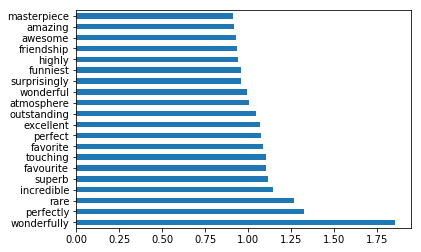

In [75]:
feature_importance = pd.Series(coefficients[0],index = X.columns)
ordered_feature_importance_pos = feature_importance[feature_importance>0].sort_values(ascending=False)
ordered_feature_importance_neg = feature_importance[feature_importance<0].sort_values()
ordered_feature_importance_pos[:20].plot.barh()
plt.show()

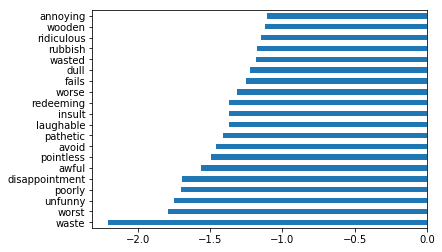

In [76]:
ordered_feature_importance_neg[:20].plot.barh()
plt.show()

In [78]:
import numpy as np

In [24]:
df['sentiment'].mean()

0.5

In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(np.array(y_test), y_pred)

0.8517235621289118

In [32]:
y_probs = lr.predict_proba(X_test)
y_probs

array([[5.41619519e-03, 9.94583805e-01],
       [6.72092133e-01, 3.27907867e-01],
       [2.87736595e-03, 9.97122634e-01],
       ...,
       [6.28027172e-01, 3.71972828e-01],
       [9.99999834e-01, 1.65688639e-07],
       [9.27840265e-04, 9.99072160e-01]])

In [43]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.array(y_test),y_probs[:,1], pos_label=1)
roc_auc = metrics.auc(fpr,tpr)
roc_auc

0.9232190749333776

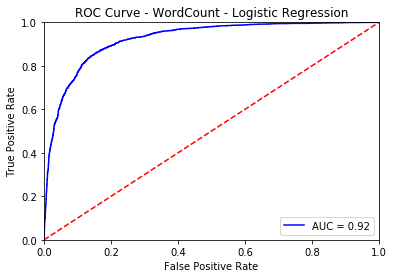

In [59]:
import matplotlib.pyplot as plt
plt.plot(fpr,tpr, 'b',label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve - WordCount - Logistic Regression')
plt.show()

In [30]:
y_pred_train = lr.predict(X_train)
roc_auc_score(np.array(y_train), y_pred_train)

0.8929348732436045

## 2. Tfidf

In [50]:
vectorizer2=TfidfVectorizer(ngram_range=(1,1),\
                             token_pattern=r'\b[a-zA-Z0-9]{4,20}\b',\
                             stop_words=stop,max_features=1500)
# vectorize the corpus
vector = vectorizer2.fit_transform(lemma_reviews)
X2 = vector
X2 =pd.DataFrame(X2.toarray(),columns=vectorizer2.get_feature_names())
X2.shape

(25000, 1500)

In [51]:
X2.head()

,ability,able,absolute,absolutely,absurd,academy,accent,accept,accident,according,...,wrong,wrote,yeah,year,york,young,younger,youth,zero,zombie
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.052342,0.0,0.064267,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.052342,0.0,0.064267,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [52]:
X_train2, X_test2, y_train, y_test = train_test_split( X2, Y, test_size = 0.3, random_state = 100)

In [53]:
lr2 = LogisticRegression()
lr2.fit(X_train2,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [54]:
y_probs2 = lr2.predict_proba(X_test2)
y_probs2

array([[0.0778811 , 0.9221189 ],
       [0.60613219, 0.39386781],
       [0.11933596, 0.88066404],
       ...,
       [0.66372168, 0.33627832],
       [0.99725426, 0.00274574],
       [0.03432531, 0.96567469]])

In [55]:
fpr2, tpr2, thresholds2 = metrics.roc_curve(np.array(y_test),y_probs2[:,1], pos_label=1)
roc_auc2 = metrics.auc(fpr2,tpr2)
roc_auc2

0.9383565326330116

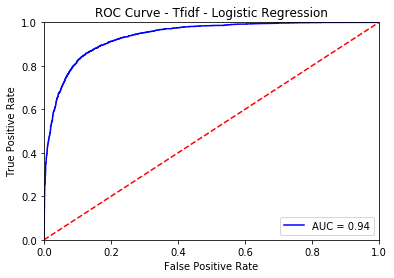

In [58]:
import matplotlib.pyplot as plt
plt.plot(fpr2,tpr2, 'b',label='AUC = %0.2f' % roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve - Tfidf - Logistic Regression')
plt.show()

In [62]:
coefficients2 = lr2.coef_
coefficients2

array([[-1.11642556,  0.98025818, -0.1302288 , ..., -0.41107062,
        -0.50521228, -0.63758248]])

In [72]:
feature_importance2 = pd.Series(coefficients2[0],index = X2.columns)
ordered_feature_importance2_pos = feature_importance2[feature_importance2>0].sort_values(ascending=False)
ordered_feature_importance2_neg = feature_importance2[feature_importance2<0].sort_values()
ordered_feature_importance2_pos[:5]

great        5.365630
excellent    5.291250
perfect      4.613659
wonderful    4.376320
best         4.329759
dtype: float64

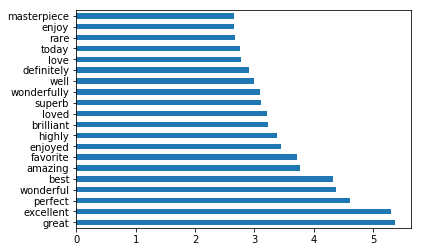

In [73]:
ordered_feature_importance2_pos[:20].plot.barh()
plt.show()

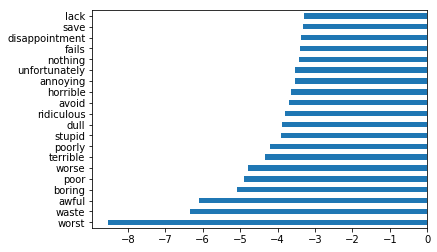

In [74]:
ordered_feature_importance2_neg[:20].plot.barh()
plt.show()

## Clustering